In [28]:
%matplotlib inline

import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time
import warnings

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from tqdm import tqdm_notebook

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [29]:
H_list = [1, 21, 42, 63]        # Forecast horizon we will be testing, in days. Note there are about 252 trading days in a year
train_size = 252*3              # Use 3 years of data as train set. Note there are about 252 trading days in a year
val_size = 252                  # Use 1 year of data as validation set

fontsize = 14
ticklabelsize = 14
####################################

train_val_size = train_size + val_size # Size of train+validation set
print("No. of days in train+validation set = " + str(train_val_size))

No. of days in train+validation set = 1008


In [30]:
print("We will start forecasting on day %d" % (train_val_size+1))

We will start forecasting on day 1009


In [31]:
def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def get_mae(a, b):
    """
    Comp mean absolute error e_t = E[|a_t - b_t|]. a and b can be lists.
    Returns a vector of len = len(a) = len(b)
    """
    return np.mean(abs(np.array(a)-np.array(b)))

def get_rmse(a, b):
    """
    Comp RMSE. a and b can be lists.
    Returns a scalar.
    """
    return math.sqrt(np.mean((np.array(a)-np.array(b))**2))

def get_preds_last_val(data, H):
    """
    Given a series data, use its last value to forecast for the next H timesteps
    """
    return np.array([data[-1]]*H)

In [32]:
df = pd.read_csv("C:/Users/steven.luo/Documents/Machine Learning/XGBoost stock predict/Naive and Prophet/TUP (2).csv", sep = ",")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-10-11,30.100000,30.670000,29.820000,30.520000,28.732052,864300
1,2018-10-12,31.000000,31.049999,29.830000,30.090000,28.327242,630300
2,2018-10-15,29.860001,31.490000,29.860001,31.090000,29.268660,462500
3,2018-10-16,31.360001,32.849998,30.920000,32.700001,30.784342,774800
4,2018-10-17,31.629999,32.459999,30.990000,32.049999,30.172419,613600
...,...,...,...,...,...,...,...
1251,2023-10-03,1.400000,1.410000,1.270000,1.310000,1.310000,1678300
1252,2023-10-04,1.350000,1.460000,1.250000,1.270000,1.270000,2960900
1253,2023-10-05,1.250000,1.320000,1.210000,1.260000,1.260000,1277800
1254,2023-10-06,1.270000,1.310000,1.230000,1.260000,1.260000,1032100


In [33]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

,date,open,high,low,close,adj_close,volume
0,2018-10-11 00:00:00,30.100000,30.670000,29.820000,30.520000,28.732052,864300
1,2018-10-12 00:00:00,31.000000,31.049999,29.830000,30.090000,28.327242,630300
2,2018-10-15 00:00:00,29.860001,31.490000,29.860001,31.090000,29.268660,462500
3,2018-10-16 00:00:00,31.360001,32.849998,30.920000,32.700001,30.784342,774800
4,2018-10-17 00:00:00,31.629999,32.459999,30.990000,32.049999,30.172419,613600
5,2018-10-18 00:00:00,31.840000,32.180000,31.080000,31.170000,29.343973,631300
6,2018-10-19 00:00:00,30.910000,31.980000,30.799999,31.309999,29.475771,736600
7,2018-10-22 00:00:00,31.459999,32.049999,31.430000,31.709999,29.852335,545200
8,2018-10-23 00:00:00,31.379999,32.709999,31.190001,32.360001,30.464260,822900
9,2018-10-24 00:00:00,35.459999,38.689999,34.900002,37.090000,34.917160,3934500


In [34]:
df['date'].min(), df['date'].max() 

(Timestamp('2018-10-11 00:00:00'), Timestamp('2023-10-09 00:00:00'))

Text(0, 0.5, 'USD')

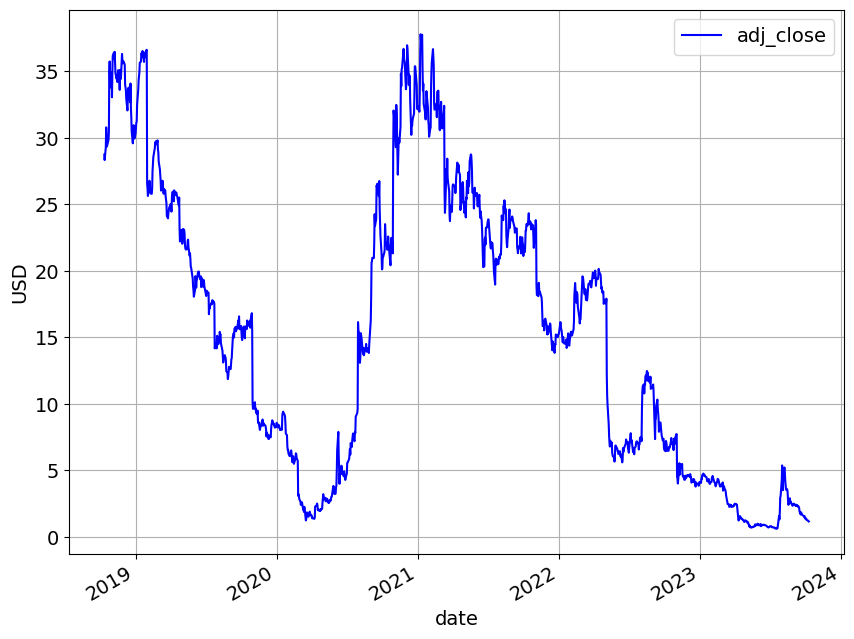

In [35]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Predict using Last Value, for a specific H and a specific date

In [36]:
i = train_val_size # Predict for day i, for the next H-1 days. Note indexing of days start from 0.
H = 21 # We will test with this value of H and observe the results
print("Predicting on day %d, date %s, with forecast horizon H = %d" % (i, df.iloc[i]['date'], H))

Predicting on day 1008, date 2022-10-13 00:00:00, with forecast horizon H = 21


In [37]:
# Run prediction
preds_list = get_preds_last_val(df['adj_close'][i-train_val_size:i].values, H)

In [38]:
print("For forecast horizon %d, predicting on day %d, date %s, the RMSE is %f" % (H, i, df['date'][i], get_rmse(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAPE is %f" % (H, i, df['date'][i], get_mape(df[i:i+H]['adj_close'], preds_list)))
print("For forecast horizon %d, predicting on day %d, date %s, the mean MAE is %f" % (H, i, df['date'][i], get_mae(df[i:i+H]['adj_close'], preds_list)))

For forecast horizon 21, predicting on day 1008, date 2022-10-13 00:00:00, the RMSE is 1.255510
For forecast horizon 21, predicting on day 1008, date 2022-10-13 00:00:00, the mean MAPE is 18.256516
For forecast horizon 21, predicting on day 1008, date 2022-10-13 00:00:00, the mean MAE is 0.949524


(19250.0, 19285.0)

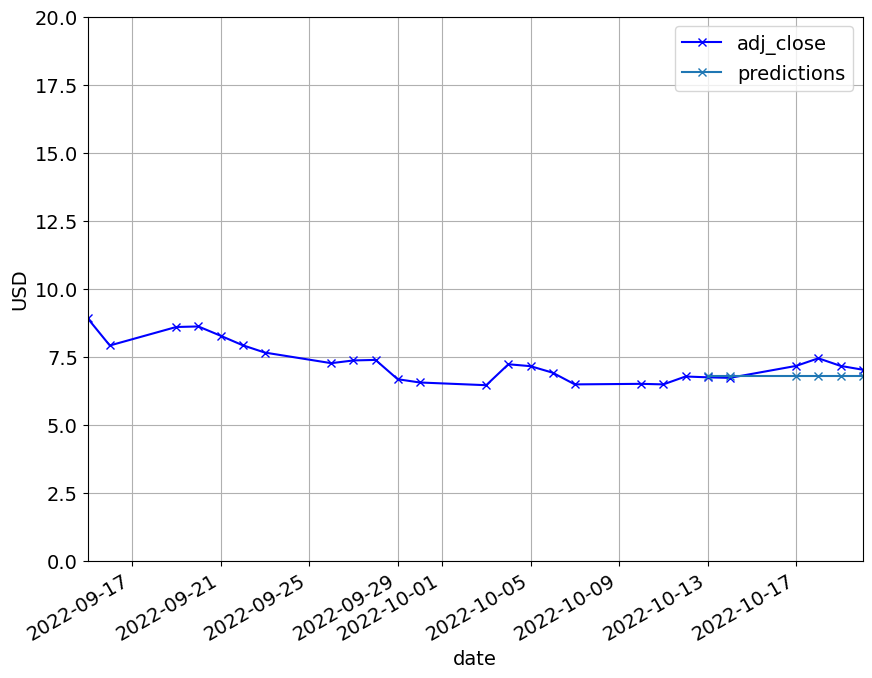

In [39]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
matplotlib.rcParams.update({'font.size': 14})

ax = df.plot(x='date', y='adj_close', style='bx-', grid=True)

# Plot the predictions
ax.plot(df['date'][i:i+H], preds_list, marker='x')
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([0, 20])
ax.set_xlim([date(2022, 9, 15), date(2022, 10, 20)])

# Predict using Last Value, for a specific H (forecast horizon)

In [40]:
rmse = [] # root mean square error
mape = [] # mean absolute percentage error
mae = []  # mean absolute error
preds_dict = {}
H = 21 # We will test with this value of H and observe the results
i_list = range(train_val_size, len(df)-21, 42)
for i in i_list:
# for i in tqdm_notebook(range(train_val_size, len(df)-H, int(H/2))): # Do a forecast on day i
    print("Predicting on day %d, date %s" % (i, df['date'][i]))
    preds_list = get_preds_last_val(df['adj_close'][i-train_val_size:i].values, H)
    
    # Collect the predictions
    preds_dict[i] = preds_list
    
    # Compute error metrics
    rmse.append(get_rmse(df[i:i+H]['adj_close'], preds_list))
    mape.append(get_mape(df[i:i+H]['adj_close'], preds_list))
    mae.append(get_mae(df[i:i+H]['adj_close'], preds_list))

print("Altogether we made %d forecasts, each of length %d days" % (len(rmse), H))

Predicting on day 1008, date 2022-10-13 00:00:00
Predicting on day 1050, date 2022-12-13 00:00:00
Predicting on day 1092, date 2023-02-14 00:00:00
Predicting on day 1134, date 2023-04-17 00:00:00
Predicting on day 1176, date 2023-06-15 00:00:00
Predicting on day 1218, date 2023-08-16 00:00:00
Altogether we made 6 forecasts, each of length 21 days


In [41]:
print("For forecast horizon %d, the mean RMSE is %f" % (H, np.mean(rmse)))
print("For forecast horizon %d, the mean MAPE is %f" % (H, np.mean(mape)))
print("For forecast horizon %d, the mean MAE is %f" % (H, np.mean(mae)))

For forecast horizon 21, the mean RMSE is 0.664905
For forecast horizon 21, the mean MAPE is 25.461948
For forecast horizon 21, the mean MAE is 0.558175


In [42]:
results = pd.DataFrame({'day': i_list,
                        'rmse': rmse,
                        'mape': mape,
                        'mae': mae})
results

,day,rmse,mape,mae
0,1008,1.255510,18.256516,0.949524
1,1050,0.301307,5.611199,0.244286
2,1092,0.789683,19.935199,0.598095
3,1134,0.523918,50.384281,0.471905
4,1176,0.160698,19.750236,0.143333
5,1218,0.958312,38.834256,0.941905


Text(0, 0.5, 'USD')

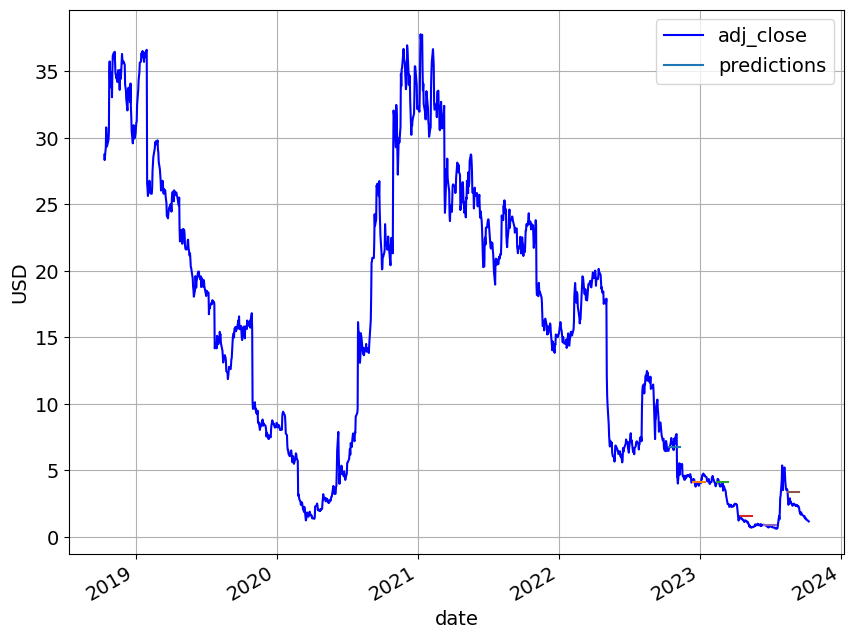

In [43]:
# Plot the predictions
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])

ax.legend(['adj_close', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

(19236.0, 19661.0)

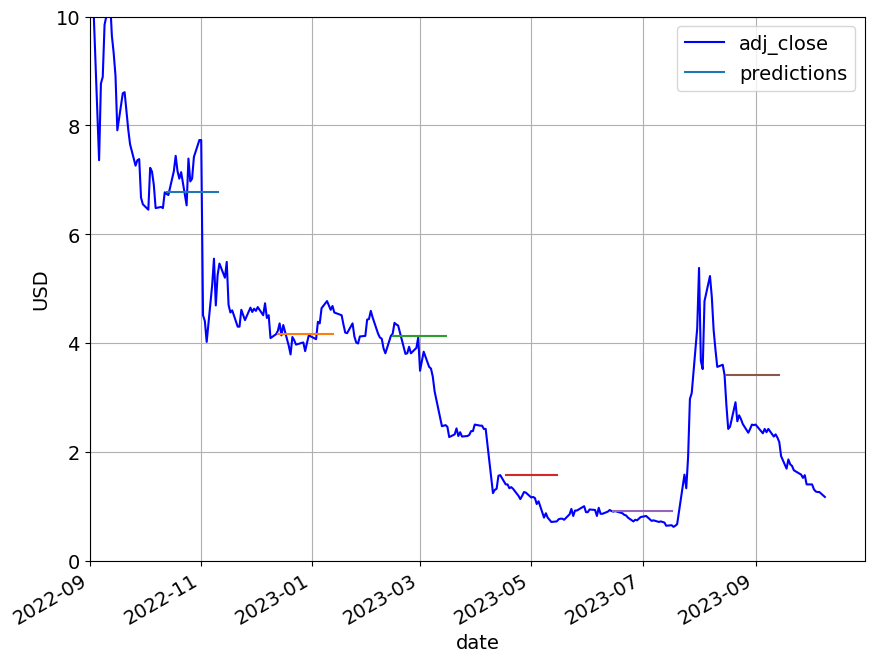

In [44]:
# Plot the predictions, and zoom in
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x='date', y='adj_close', style='b-', grid=True)

# Plot the predictions
for key in preds_dict:
    ax.plot(df['date'][key:key+H], preds_dict[key])
    
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.legend(['adj_close', 'predictions'])
ax.set_ylim([0, 10])
ax.set_xlim([date(2022, 9, 1), date(2023, 10, 31)])